# Lab - Transformers

## Integrantes
- Jose Asitimbay
- Brayan Lechon

# Instrucciones
Read the paper: 

https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf

Implement a English-Spanish translator using transformers, use this tutorial for help:

https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html

Use the attention model from class to compare a few translations.

In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import time
import math
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
# import seaborn as sns

# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

# from tqdm.auto import tqdm



# import nltk
# Descargar el tokenizador de NLTK si no está ya descargado
# nltk.download('punkt')
# nltk.download('punkt_base')

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# Dataset

In [5]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [7]:
file = 'data/spa.txt'

In [8]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    try:
        return len(p[0].split(' ')) < MAX_LENGTH and \
            len(p[1].split(' ')) < MAX_LENGTH #and \
#            p[0].startswith(eng_prefixes)
    except:
        print(p)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
def prepareData(lang1, lang2, file):
    text = open(file, encoding='utf-8').read().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')][:2] for l in text ]
    pairs = [pair for pair in pairs if len(pair) == 2]

    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    
    pairs = filterPairs(pairs)
    
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


In [10]:
input_lang, output_lang, pairs = prepareData('eng', 'spa', file)

Counted words:
eng 12105
spa 23411


In [11]:
input_lang1, output_lang1, pairs1 = prepareData('eng', 'spa', file)

Counted words:
eng 12105
spa 23411


In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'spa', file)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

# Implementacion del Transformer

In [13]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = F.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout, max_seq_length)
        
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        
        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(src.device)
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask
        
    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
        
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)
        
        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)
        
        output = self.fc(dec_output)
        return output


In [14]:
# Función de entrenamiento (similar a la existente, pero adaptada para el transformer)
def train_epoch(dataloader, model, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_tensor, target_tensor = batch
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)
        
        optimizer.zero_grad()
        
        output = model(input_tensor, target_tensor[:, :-1])
        output = output.view(-1, output.size(-1))
        target = target_tensor[:, 1:].contiguous().view(-1)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

# Función de evaluación
def evaluate(model, sentence, input_lang, output_lang):
    model.eval()
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence).unsqueeze(0)
        output_tensor = torch.LongTensor([[SOS_token]]).to(device)
        
        for _ in range(MAX_LENGTH):
            predictions = model(input_tensor, output_tensor)
            _, predicted_id = predictions[:, -1:].max(2)
            
            if predicted_id.item() == EOS_token:
                break
                
            output_tensor = torch.cat([output_tensor, predicted_id], dim=1)

        decoded_words = [output_lang.index2word[token.item()] for token in output_tensor[0][1:]]
    return decoded_words

In [15]:
from matplotlib import ticker


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train(dataloader, model, n_epochs, learning_rate, print_every=1, plot_every=1):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(dataloader, model, optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                         epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Counted words:
eng 12105
spa 23411
4m 59s (- 0m 0s) (5 100%) 2.6586


<Figure size 640x480 with 0 Axes>

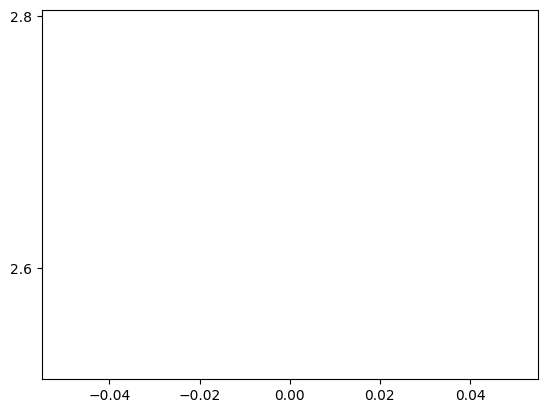

In [20]:

# Hiperparámetros
src_vocab_size = input_lang.n_words
tgt_vocab_size = output_lang.n_words
d_model = 256
num_heads = 8
num_layers = 3
d_ff = 512
max_seq_length = MAX_LENGTH
dropout = 0.1



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Inicializar el modelo
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Mover el modelo al dispositivo
transformer = transformer.to(device)

# Entrenamiento
n_epochs = 5
print_every = 5
plot_every = 5

learning_rate = 0.0001
optimizer = torch.optim.Adam(transformer.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=0)

train_dataloader = get_dataloader(32)[2]  # Asumiendo que esta función ya está definida

train(train_dataloader, transformer, n_epochs, learning_rate, print_every, plot_every)

In [17]:
# Evaluación
def evaluate(model, sentence, input_lang, output_lang):
    model.eval()
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence).unsqueeze(0)
        output_tensor = torch.LongTensor([[SOS_token]]).to(device)
        
        for _ in range(MAX_LENGTH):
            predictions = model(input_tensor, output_tensor)
            _, predicted_id = predictions[:, -1:].max(2)
            
            if predicted_id.item() == EOS_token:
                break
                
            output_tensor = torch.cat([output_tensor, predicted_id], dim=1)

        decoded_words = [output_lang.index2word[token.item()] for token in output_tensor[0][1:]]
    return decoded_words

In [22]:
import random

def evaluate(model, sentence, input_lang, output_lang, max_length=MAX_LENGTH):
    model.eval()
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence).to(device)
        target_tensor = torch.LongTensor([[SOS_token]]).to(device)

        for i in range(max_length):
            output = model(input_tensor, target_tensor)
            topv, topi = output[:, -1].topk(1)
            if topi.item() == EOS_token:
                break
            target_tensor = torch.cat([target_tensor, topi.detach()], dim=1)

        decoded_words = []
        for iti in range(target_tensor.size(1)):
            if target_tensor[0][iti].item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[target_tensor[0][iti].item()])
    
    return decoded_words

def evaluateRandomly(model, pairs, input_lang, output_lang, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(model, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

def evaluateAndShowAttention(model, sentence, input_lang, output_lang):
    output_words = evaluate(model, sentence, input_lang, output_lang)
    print('input =', sentence)
    print('output =', ' '.join(output_words))

# Uso de las funciones de evaluación
print("Evaluando ejemplos aleatorios:")
evaluateRandomly(transformer, pairs, input_lang, output_lang)


Evaluando ejemplos aleatorios:
> the sun disappeared behind the clouds
= el sol desaparecio detras de las nubes
< SOS el sol detras del nubes

> tom could never forget the terror of war
= tom nunca pudo olvidar el horror de la guerra
< SOS tom nunca podia contener la guerra de la guerra

> everything tom does is controversial
= todo lo que tom hace es controversial
< SOS tom es controversial

> please let me sleep
= dejame dormir por favor
< SOS dormir por favor

> they will come
= vienen
< SOS

> my daughter has braces
= mi hija tiene frenillos
< SOS mi hija tiene muchos libros

> we re still on our honeymoon
= todavia estamos en nuestra luna de miel
< SOS nuestros gastos

> she wrote in ink
= ella escribio con tinta
< SOS en tinta

> tom was shot by a firing squad
= tom fue fusilado por un peloton de fusilamiento
< SOS tom fue atropellado por un grave

> the dog was in the box under the table
= el perro estaba en la caja bajo la mesa


< SOS la caja estaba en la caja bajo la mesa



In [37]:
# save the model
torch.save(transformer.state_dict(), 'transformer_test_5_epochs.pth')

In [36]:
evaluateAndShowAttention(transformer, "where is the library ?", input_lang, output_lang)
# tengo un error no envez de la primera palabra me da SOS

input = where is the library ?
output = SOS es la biblioteca ?
